In [20]:
import argparse
from pathlib import Path
import numpy as np
import pickle
import string
from functools import partial
from sklearn.metrics.pairwise import cosine_similarity

from mist import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from mist.utils.plot_utils import *

In [2]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='sans serif')
# sns.set_palette(['#9e0059', '#6da7de', '#ee266d', '#dee000', '#eb861e'])
sns.set_context('paper', font_scale=1.3)

width = 7
height = width / 1.618

In [18]:
VIOLIN_PRED_FILES = [ # (filename, model, dataset)
    ("../../pretrained_models/mist_canopus_public/fp_model/preds_casmi2022/out_preds_single/merged_fp_preds.p", "MIST public", "CASMI 2022"),
    ("../../results/retrained_models/mist_fp_model_aug/preds_casmi2022/out_preds_single/merged_fp_preds.p", "MIST retrain", "CASMI 2022"),
    ("../../pretrained_models/mist_full/fp_model/preds_casmi2022/out_preds_single/merged_fp_preds.p", "MIST full", "CASMI 2022"),
    ("../../pretrained_models/mist_canopus_public/fp_model/preds_canopus_train_public/out_preds_single/merged_fp_preds.p", "MIST public", "CANOPUS public"),
    ("../../results/retrained_models/mist_fp_model_aug/preds_canopus_train_public/out_preds_single/merged_fp_preds.p", "MIST retrain", "CANOPUS public"),
    ("../../pretrained_models/mist_full/fp_model/preds_canopus_train_public/out_preds_single/merged_fp_preds.p", "MIST full", "CANOPUS public"),
    ]
METRIC_POOL_TUPLES = [("Cosine", "spectra"), 
                      ("LL","spectra"), 
                      ("LL", "bit")]

In [4]:
def get_args():
    parser = argparse.ArgumentParser()
#    parser.add_argument("--pool-method", default="spectra", choices=["spectra", "bit"])
#    parser.add_argument("--metric", default="LL", choices=["LL", "Cosine", "Tani"])
    parser.add_argument("--out-dir", default="results/fp_violin")
    parser.add_argument("--png", default=False, action="store_true")
    return parser.parse_args()


def ll(pred, targ):
    """nll.

    Args:
        pred:
        targ:
    """
    log = partial(utils.clamped_log_np, _min=-5)
    ll = targ * log(pred) + (1 - targ) * log(1 - pred)
    return ll


def cos_sim(pred, targ):
    """nll.

    Args:
        pred:
        targ:
    """
    pred

    sim = cosine_similarity(pred, targ)
    sim = np.diag(sim)
    return sim[:, None]


def tani(pred, targ):
    """tani.

    Args:
        pred:
        targ:
    """
    pred = np.copy(pred)
    above_thresh = pred >= 0.5
    pred[above_thresh] = 1.0
    pred[~above_thresh] = 0.0

    pred, targ = pred.astype(bool), targ.astype(bool)
    denom = np.logical_or(pred, targ).sum(-1)
    num = np.logical_and(pred, targ).sum(-1)
    res = num / denom
    return res[:, None]


def get_metric(metric):
    """get_metric.

    Args:
        metric:
    """
    """get_metric.

    Args:
        metric:
    """
    return {
        "LL": ll,
        "Cosine": cos_sim,
        "Tani": tani,
    }[metric]

In [16]:
def compute_fp_results(metric, pool_method, out_dir):
    # Get dataset names
    datasets = list(set([p[2] for p in VIOLIN_PRED_FILES]))
    datasets.sort()
    val_fn = get_metric(metric)

    result_df = pd.DataFrame(columns=["score", "model", "dataset"])

    for dataset in datasets:
        print(f"current dataset: {dataset}")

        dataset_preds = [p for p in VIOLIN_PRED_FILES if p[2] == dataset]
        keep_sets = []

        all_names, all_preds, all_targs, all_res = [], [], [], []

        for fp_pred_file, _, _ in dataset_preds:

            fp_preds = pickle.load(open(fp_pred_file, "rb"))

            names, preds, targs = fp_preds["names"], fp_preds["preds"], fp_preds["targs"]
            _, unique_idx = np.unique(names, return_index=True)

            all_names.append(names[unique_idx])
            all_preds.append(preds[unique_idx])
            all_targs.append(targs[unique_idx])

            keep_sets.append(list(set(names)))
            print(f"number of names: {len(names)}")


        keep_set = set.intersection(*map(set, keep_sets))

        for i in range(len(all_names)):
            keep = np.asarray([n in keep_set for n in all_names[i]], dtype=bool)
            all_names[i], all_preds[i], all_targs[i] = all_names[i][keep], all_preds[i][keep], all_targs[i][keep]
            sort = np.argsort(all_names[i])
            all_names[i], all_preds[i], all_targs[i] = all_names[i][sort], all_preds[i][sort], all_targs[i][sort]

            res = val_fn(all_preds[i], all_targs[i])
            print(f"Mean values 1: {res.mean()}")
            if pool_method == "spectra":
                res = res.mean(1)
            elif pool_method == "bit":
                res = res.mean(0)
            all_res.append(res)
            print(f"shape results: {res.shape}")
        assert all([np.all(all_targs[i] == all_targs[0]) for i in range(len(all_targs))])

        for i, (_, model_name, dataset) in enumerate(dataset_preds):
            res = pd.DataFrame(all_res[i], columns=["score"])
            res["model"] = model_name
            res["dataset"] = dataset
            result_df = pd.concat([result_df, res], ignore_index=True)


    out_dir.mkdir(exist_ok=True)
    save_file = out_dir / f"result_df_{metric}_{pool_method}.p"
    with open(save_file, "wb") as f:
        pickle.dump(result_df, f)

    return result_df

In [31]:
def plot_violins(metric_pool_tuples, result_dfs, png, out_dir):

    fig, axes = plt.subplots(1, len(result_dfs), figsize=(width * 2.2, height))
    sns.set_context("paper")

    for i, ((metric, pool_method), res_df, ax) in enumerate(zip(metric_pool_tuples, result_dfs, axes)):
        metric_title = {
            "LL": "Log likelihood",
            "Cosine": "Cosine similarity",
            "Tani": "Tanimoto similarity",
        }.get(metric)
        pool_to_title = {"bit": "(fingerprint bits)", "spectra": "(spectra)"}.get(
            pool_method
        )
        ax.set_title(f"{metric_title}\n{pool_to_title}")

        ax.set_box_aspect(1)

        sns.violinplot(
            data=res_df,
            x="dataset",
            y="score",
            hue="model",
            cut=0,
            palette=sns.color_palette("tab10"),
            # linewidth=1,
            legend=False,
            ax=ax
        )

        ax.get_legend().remove()
        ax.set(xlabel=None)
        ax.set(ylabel=None)

        ax.text(-0.1, 1.1, string.ascii_lowercase[i+3], transform=ax.transAxes, size=15, weight='bold')

    axes[0].set_ylabel("Score")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(result_dfs)) # , prop={'size': 15}

    ext = "png" if png else "pdf"
    save_name = f"violins.{ext}"
    save_name = out_dir / save_name
    plt.savefig(save_name, format="pdf", bbox_inches="tight", dpi=600, transparent=True)

current dataset: CANOPUS public
number of names: 819
number of names: 819
number of names: 10709
Mean values 1: 0.6992460916943783
shape results: (819,)
Mean values 1: 0.682938451151743
shape results: (819,)
Mean values 1: 0.8617903199455968
shape results: (819,)
current dataset: CASMI 2022
number of names: 170
number of names: 170
number of names: 170
Mean values 1: 0.49189803029998586
shape results: (170,)
Mean values 1: 0.4880990239905105
shape results: (170,)
Mean values 1: 0.5279082822247306
shape results: (170,)
current dataset: CANOPUS public
number of names: 819
number of names: 819
number of names: 10709
Mean values 1: -0.024643290787935257
shape results: (819,)
Mean values 1: -0.02391689456999302
shape results: (819,)
Mean values 1: -0.011903990060091019
shape results: (819,)
current dataset: CASMI 2022
number of names: 170
number of names: 170
number of names: 170
Mean values 1: -0.03573821485042572
shape results: (170,)
Mean values 1: -0.035125669091939926
shape results: (1

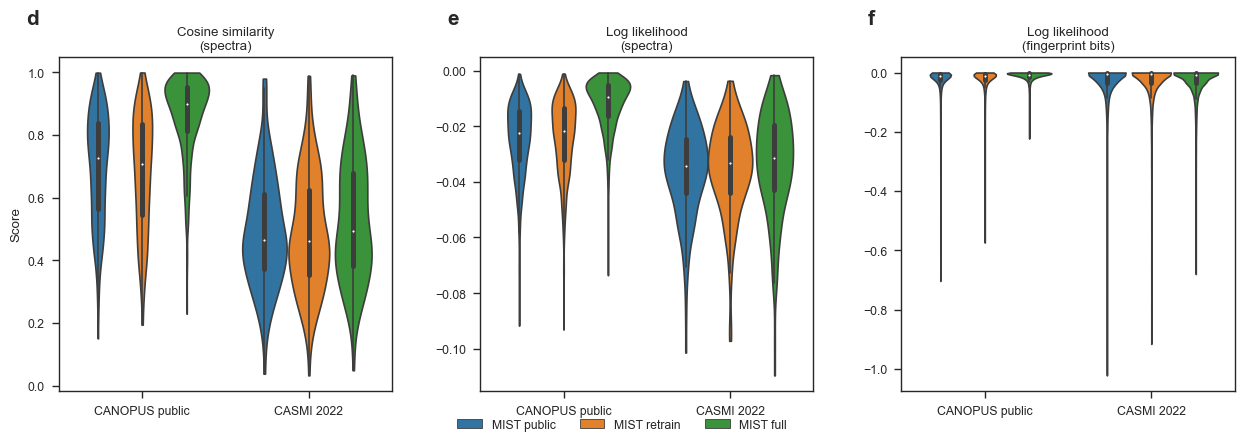

In [32]:
out_dir = Path("../../results/reusability/fp_violin")

result_dfs = []
for metric, pool_method in METRIC_POOL_TUPLES:
    res = compute_fp_results(metric, pool_method, out_dir)
    result_dfs.append(res)

plot_violins(METRIC_POOL_TUPLES, result_dfs, png=False, out_dir=out_dir)